In [1]:
import pandas as pd
import numpy as np

# not skipping empty values, to demonstrate data preprocessing steps later
df = pd.read_csv('web_log_data.csv', na_filter=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 6 columns):
ip           5866 non-null object
date_time    5866 non-null object
request      5866 non-null object
step         5866 non-null int64
session      5866 non-null int64
user_id      5866 non-null int64
dtypes: int64(3), object(3)
memory usage: 275.0+ KB


In [2]:
# preview
df.head()

,ip,date_time,request,step,session,user_id
0,c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3
1,visp.inabox.telstra.,19/Apr/2005:08:24:28,/,1,12,12
2,dsl-61-95-54-84.requ,19/Apr/2005:08:33:01,/,1,13,13
3,d220-236-91-52.dsl.n,19/Apr/2005:09:16:06,/,1,15,15
4,allptrs.eq.edu.au,19/Apr/2005:09:47:54,/,1,22,22


In [3]:
df['request'].value_counts()

/                                                                821
/favicon.ico                                                     554
/robots.txt                                                      395
/eaglefarm/javascript/menu.js                                    370
/eaglefarm/pdf/Web_Price_List.pdf                                296
/eaglefarm/                                                      286
/services.html                                                   244
/eaglefarm/pricelist/                                            189
/eaglefarm/pricelist                                             187
/more.html                                                       145
/direct.html                                                     107
/eaglefarm/specials/                                             103
/eaglefarm/contact                                                95
/eaglefarm/contact/                                               93
/eaglefarm                        

In [4]:
# removing unproductive items from the log file such as graphics, sound, etc;

# correct the incorrect dataframe types
df['Datetime'] = pd.to_datetime(df['date_time'], format='%d/%b/%Y:%H:%M:%S')  # set date time to pandas datatime obj
df = df.drop(['date_time'], axis=1)

# create a mask to filter all images
mask = (df['request'].str.endswith('.ico') | df['request'].str.endswith('.jpg') | df['request'].str.endswith('.jpeg') | df['request'].str.endswith('.mp3'))
print("# Rows before:", len(df))

# invert the mask, only keep records without .gif, .jpg and .jpeg in the request column
df2 = df[~mask]

print("After images removal", len(df2))

# Rows before: 5866
After images removal 5312


In [5]:
df2.head()

,ip,request,step,session,user_id,Datetime
0,c210-49-32-6.rochd2.,/,1,3,3,2005-04-18 21:25:07
1,visp.inabox.telstra.,/,1,12,12,2005-04-19 08:24:28
2,dsl-61-95-54-84.requ,/,1,13,13,2005-04-19 08:33:01
3,d220-236-91-52.dsl.n,/,1,15,15,2005-04-19 09:16:06
4,allptrs.eq.edu.au,/,1,22,22,2005-04-19 09:47:54


### Association mining is aimed to applied on the pre-processed data set

In [6]:
# group by user_id, then list all requests
user_behaviour = df2.groupby(['user_id'])['request'].apply(list)

In [7]:
print(user_behaviour.head(5))

user_id
1                                       [/robots.txt]
2                       [/code/Global/code/menu.html]
3    [/, /guarantee.html, /more.html, /services.html]
4                                       [/robots.txt]
5                          [/code/Ultra/services.htm]
Name: request, dtype: object


In [8]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
user_behaviourn_list = list(user_behaviour)
results = list(apriori(user_behaviourn_list, min_support=0.05))

# print first 5 rules
print(results[:5])

[RelationRecord(items=frozenset({'/'}), support=0.3776041666666667, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'/'}), confidence=0.3776041666666667, lift=1.0)]), RelationRecord(items=frozenset({'/eaglefarm/'}), support=0.13177083333333334, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'/eaglefarm/'}), confidence=0.13177083333333334, lift=1.0)]), RelationRecord(items=frozenset({'/eaglefarm/javascript/menu.js'}), support=0.14479166666666668, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'/eaglefarm/javascript/menu.js'}), confidence=0.14479166666666668, lift=1.0)]), RelationRecord(items=frozenset({'/eaglefarm/pdf/Web_Price_List.pdf'}), support=0.08385416666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'/eaglefarm/pdf/Web_Price_List.pdf'}), confidence=0.08385416666666666, lift=1.0)]), RelationRecord(items=frozenset({'/eaglefarm/pricelist

In [9]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

                            Left_side                         Right_side  \
0                                                                      /   
1                                                            /eaglefarm/   
2                                          /eaglefarm/javascript/menu.js   
3                                      /eaglefarm/pdf/Web_Price_List.pdf   
4                                                   /eaglefarm/pricelist   
5                                                  /eaglefarm/pricelist/   
6                                                   /eaglefarm/specials/   
7                                                             /more.html   
8                                                            /robots.txt   
9                                                         /services.html   
10                                  /                         /more.html   
11                         /more.html                                  /   
12          

In [10]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(10))

                                            Left_side             Right_side  \
51                   /eaglefarm/pricelist,/eaglefarm/  /eaglefarm/pricelist/   
86  /eaglefarm/javascript/menu.js,/eaglefarm/,/eag...  /eaglefarm/pricelist/   
48      /eaglefarm/,/eaglefarm/pdf/Web_Price_List.pdf  /eaglefarm/pricelist/   
70  /eaglefarm/javascript/menu.js,/eaglefarm/,/eag...  /eaglefarm/pricelist/   
74  /eaglefarm/javascript/menu.js,/eaglefarm/,/eag...  /eaglefarm/pricelist/   
78  /eaglefarm/pricelist,/eaglefarm/,/eaglefarm/pd...  /eaglefarm/pricelist/   
57  /eaglefarm/javascript/menu.js,/eaglefarm/pdf/W...  /eaglefarm/pricelist/   
82  /eaglefarm/javascript/menu.js,/eaglefarm/pdf/W...  /eaglefarm/pricelist/   
60  /eaglefarm/javascript/menu.js,/eaglefarm/price...  /eaglefarm/pricelist/   
63  /eaglefarm/pricelist,/eaglefarm/pdf/Web_Price_...  /eaglefarm/pricelist/   

     Support  Confidence       Lift  
51  0.075000    1.000000  11.098266  
86  0.065104    1.000000  11.098266  
48  0

### Clustering mining is aimed to applied on the pre-processed data set

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('web_log_data.csv', na_filter=False)

df_clus = df

lis = []
for str in df['date_time']:
    lis.append(int(str[12:14]))

ds = pd.Series(lis)

df_clus['date_time'] = ds

#Distribution of step
regdens_dist = sns.distplot(df_clus['step'].dropna())
plt.show()

# Distribution of session
medhhinc_dist = sns.distplot(df_clus['date_time'].dropna())
plt.show()

# Distribution of user_id
meanhhsz_dist = sns.distplot(df_clus['user_id'].dropna())

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [12]:
from sklearn.preprocessing import StandardScaler

# take 3 variables and drop the rest
df_clustering = df_clus[['step', 'date_time', 'user_id']]

# convert df2 to matrix
X = df_clustering.as_matrix()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
from sklearn.cluster import KMeans
# list to save the clusters and cost
clusters = []
inertia_vals = []
rs = 42

# this whole process should take a while
for k in range(2, 10, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

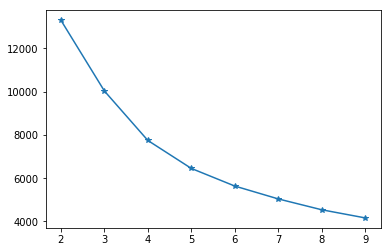

In [14]:
# plot the inertia vs K values
plt.plot(range(2,10,1), inertia_vals, marker='*')
plt.show()

In [15]:
from sklearn.metrics import silhouette_score

print(clusters[2])
print("Silhouette score for k=4", silhouette_score(X, clusters[2].predict(X)))

print(clusters[3])
print("Silhouette score for k=5", silhouette_score(X, clusters[3].predict(X)))

print(clusters[4])
print("Silhouette score for k=6", silhouette_score(X, clusters[4].predict(X)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.2978571720208956
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.2882913739903998
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.29330562334481913


Sum of intra-cluster distance: 7743.2181659084
Centroid locations:
[-0.2756924  -0.95903658 -0.85598041]
[-0.22632888 -0.16015474  0.96930961]
[-0.18656132  0.8438766  -0.54588362]
[2.64318827 0.40533924 0.10780469]
Cluster membership
1    2203
2    1795
0    1407
3     461
Name: Cluster_ID, dtype: int64


C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Computer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Computer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


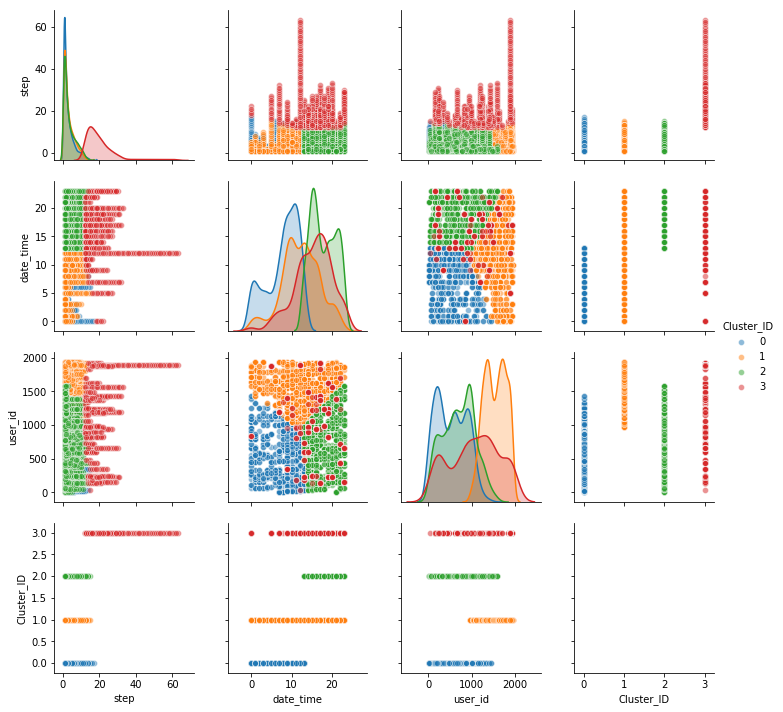

In [16]:
# visualisation of K=4 clustering solution
model = KMeans(n_clusters=4, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

y = model.predict(X)
df_clustering['Cluster_ID'] = y

# how many in each
print("Cluster membership")
print(df_clustering['Cluster_ID'].value_counts())

# pairplot
# added alpha value to assist with overlapping points
cluster_g = sns.pairplot(df_clustering, hue='Cluster_ID', plot_kws={'alpha': 0.5})
plt.show()

#### a. The rationale for selecting the specific operation/method.

We chose clustering to identify user groups for making personalised marketing strategies according to the characteristics of clusters.

#### b. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

There are 3 variables which are User id, time (24 hour) and step. All 5866 data were utilised in the clustering. We chose these variables in order to analyse which period of time users visit the most, which users often visit the website in which period in a day.

#### c. Can you identify data quality issues in order to perform web mining?
The original data include both date and time but in the clustering, we only need the hour of visting, so we did some works to change it to the format we need.

#### d. Discuss the results obtained. Discuss also the applicability of findings of the method. Should include a high-level managerial kind of discussion on the findings, should not be just interpretation of results as shown in the results panel.

According to first row, second column, cluster 0, 1, 2 are generally have low steps and cluster 3 has higher steps, also, only a few visit is in the middile of night (from 0 to 4 o'clock). According to the second row, third colume, cluster 0 are generally active from 0 to 11 and cluster 2 are active from 12 to 23. 

Cluster 0: User id from 0 - 1500 visit in the middle of the night or morning (from 0 - 11), steps are few.

Cluster 1: User id from about 1000 to 2000 have few steps.

Cluster 2: Visits in the afternoon or evening (from 12 to 24) have few steps. 

Cluster 3: Users in the day time with a lot steps.